### Document specifications
Author: Dominik Wulf <br>
Matriculation Number: 364 100 <br>
Creation Date: 05. July 2022

### Intro

For the code various websites were used as references and get information about the implementation of the LDA models. The references used in the code below are the following: <br>

* https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
* https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2
* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
* https://nicharuc.github.io/topic_modeling/

In [1]:
#import needed libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import gensim
import nltk
import re
import spacy
import en_core_web_sm
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import unicodedata
import regex as rx
import qgrid

from tqdm import tqdm
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from nltk.stem import WordNetLemmatizer, SnowballStemmer

C:\Users\dominik\Anaconda3\lib\site-packages\qgrid\grid.py:30: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pd.__version__) > LooseVersion('0.20.0'):
C:\Users\dominik\Anaconda3\lib\site-packages\qgrid\grid.py:30: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pd.__version__) > LooseVersion('0.20.0'):
C:\Users\dominik\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py:282: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
C:\Users\dominik\Anaconda3\lib\site-packages\qgrid\grid.py:573: DeprecationWarning: metadata {'sync': True} was set from the constructor. With traitlets 4.1, metadata should be set using t

In [2]:
#import stop word list
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### ! BEFORE START SET FILEPATH AND IMPORT DATA HERE ! 

In [41]:
# import data, please insert file link to '220705_html_content_normalized.csv' file
data = pd.read_csv('C:/Users/dominik/Documents/GitHub/Masterthesis/LDA/Data/220705_html_content_normalized.csv', sep=',') 
# randomize data set
data = data.sample(frac=1, random_state = 1)

In [4]:
# view data
data

,links,html_content,word_count
723,https://ethereals.wtf/#team,HOME\nSTORY\nROADMAP\nTEAM\nNFT BASICS\nFAQ\nD...,212
1012,https://superplastic.co/collections/frontpage/...,DEFAULT TITLE\nADD TO BAG\nCase Of 12 Blindbox...,12
1683,https://eulerbeats.com/,Drops\nStake\nDocs\nContact\nFutura is here!\n...,140
1717,https://www.coolcatsnft.com/competition-rules/...,CONNECT\nCool Cats Candy Bucket Giveaway Rules...,2863
1695,https://www.divineanarchy.com/edition-3-the-bu...,ABOUT\nFAQ\nNEWS\nPLAY NOW\nEDITION 3: THE BUR...,426
...,...,...,...
715,https://nfp.daz3d.com/frequently-asked-questions,NFPets\nPartnerships\nUtility\nRoadmap\nTeam\n...,221
905,https://www.dgenesis.io/collections/prime/drips,ARBIDRIPS MINT FOR BRIDGEOOORS IS NOW LIVE - M...,673
1096,https://0xadventures.com/,Adventure Cards\nDiscord\nOpensea\nTwitter\nCo...,82
235,https://tubbycats.club/@ratwell,Profilverzeichnis\nÜber diesen Server\nMobile ...,230


In [5]:
# create corpus
documents = data['html_content']
documents = pd.DataFrame(documents)

In [6]:
# define functions to remove html content and long and short words

CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

def remove_sandl_words(s,s_count,l_count):
    return ' '.join([w for w in s.split() if len(w)>s_count and len(w)<l_count])

In [7]:
def preprocess(df):

    # remove html tags from data
    df['text_preprocessed'] = df.iloc[:, 0].str.replace(r"->","")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"<-","")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"[","<")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"]",">")
    df['text_preprocessed'] = df.iloc[:, 1].apply(cleanhtml)

    #remove control characters
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: rx.sub(r'\p{C}', ' ',x))
    
    #remove emails
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: rx.sub(r'\S*@\S*\s?', '',x))
    
    # remove punctuation
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: re.sub(r'[,\.!?]', '', x))

    # remove words shorter than 3
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: remove_sandl_words(x,2,20))
    
    # change to lowercase letters
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: x.lower())
    
    return df

In [8]:
# take first preprocessing step and clean html content
documents = preprocess(documents)

In [9]:
# count words and append as column
documents["word_count"] = documents['text_preprocessed'].str.split().str.len()

In [10]:
# check dataframe if preprocessing was successful
documents.head()

,html_content,text_preprocessed,word_count
723,HOME\nSTORY\nROADMAP\nTEAM\nNFT BASICS\nFAQ\nD...,home story roadmap team nft basics faq discord...,175
1012,DEFAULT TITLE\nADD TO BAG\nCase Of 12 Blindbox...,default title add bag case blindboxes single b...,9
1683,Drops\nStake\nDocs\nContact\nFutura is here!\n...,drops stake docs contact futura here futura th...,113
1717,CONNECT\nCool Cats Candy Bucket Giveaway Rules...,connect cool cats candy bucket giveaway rules ...,2340
1695,ABOUT\nFAQ\nNEWS\nPLAY NOW\nEDITION 3: THE BUR...,about faq news play now edition the bureau hel...,348


In [11]:
# check single doc if preprocessing was successful
documents.iloc[4][1]

'about faq news play now edition the bureau hello citizens the bureau finally here part the ecosystem you have the ability interact with new in-discord ecosystem where you will tasked with the duty leveling the highest echelons society are moving along day day with incredible progress this newsletter will sharing some the most exciting announcements this week make sure take the next minutes check out the amazing updates taking place our ecosystem agenda: dev team updates: some this week’s sprint deliverables listed from last week’s newsletter will rolling over into this next sprint (sprint one the reasons why these deliverables are rolling over because spent time this past sprint onboarding for the team which was rigorous process order structure our organization based current needs among this giant onboarding process have added few new developers: cjay react architect lefty react developer backend architect skaro react developer sprint goals for sprint creating signature protocol allow

In [12]:
# remove website with more than 10.000 words 
documents = documents[documents["word_count"]<10000]

In [13]:
# count number of words in corpus
num_words = documents["word_count"].sum()
num_words

698042

In [14]:
# create bag of words for 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

In [15]:
data = documents.text_preprocessed.values.tolist()
documents_words = list(sent_to_words(data))

In [16]:
# Build the bigram models
bigram = gensim.models.Phrases(documents_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [17]:
stop_words = stopwords.words('english')

stop_words.extend(stopwords.words('german'))

stop_words.extend(['blockchain','bitcoin','ethereum','technology','nft','nfts','mint','javascript','terms','condition','websites','terms','service'
                   ,'website','cookie','impressum','imprint','etc','cookies'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(documents_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp.max_length = 1500000

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['home', 'story', 'roadmap', 'team', 'basic', 'buy', 'shop', 'contact', 'eth', 'minting', 'est', 'origin', 'wormhole', 'sheet', 'ethereal', 'fun', 'park', 'operator', 'chaos', 'operator', 'etherealtron', 'win', 'create', 'playing', 'explore', 'sharing', 'make', 'ethereal', 'artist', 'ghost', 'active', 'player', 'community', 'painstakingly', 'draw', 'ethereal', 'hand', 'digitize', 'creator', 'banana', 'know', 'hyper', 'realistic', 'oil', 'painting', 'toy', 'pop_culture', 'icon', 'work', 'feature', 'private', 'collection', 'world', 'collaboration', 'brand', 'converse', 'work', 'feature', 'major', 'industry', 'publication', 'forbe', 'lead', 'artist', 'warhodl', 'marketing', 'strategy', 'support', 'event', 'planning', 'event', 'partnership', 'bayc', 'hodler', 'marketing', 'community', 'head', 'market', 'social_media', 'strategist', 'event', 'manager', 'bayc', 'hodler', 'mnmlty', 'project', 'management', 'product', 'development', 'lead', 'developer', 'laser', 'falcon', 'brand', 'developmen

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 3), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 4), (25, 1), (26, 3), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 3), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1)]]


In [20]:
# count words after preprocessing
words_total = 0
for t in texts:
    x = len(t)
    words_total = words_total + x
words_total

351614

In [21]:
#initilize first LDA Model
from multiprocessing import Process, freeze_support
if __name__ == "__main__":
    freeze_support()
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=7, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    # Print the Keyword in the 8 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]

[(0,
  '0.037*"information" + 0.025*"use" + 0.024*"datum" + 0.019*"personal" + '
  '0.012*"collect" + 0.010*"right" + 0.010*"include" + 0.009*"provide" + '
  '0.009*"process" + 0.009*"email"'),
 (1,
  '0.015*"art" + 0.012*"collection" + 0.010*"eth" + 0.008*"artist" + '
  '0.008*"unique" + 0.008*"project" + 0.007*"piece" + 0.007*"mint" + '
  '0.006*"create" + 0.006*"new"'),
 (2,
  '0.035*"claim" + 0.024*"set" + 0.020*"buy" + 0.019*"wallet" + '
  '0.014*"product" + 0.013*"order" + 0.012*"connect" + 0.012*"opensea" + '
  '0.011*"blocknumber_number" + 0.011*"phase"'),
 (3,
  '0.012*"game" + 0.010*"community" + 0.008*"collection" + 0.008*"team" + '
  '0.007*"world" + 0.006*"create" + 0.006*"metaverse" + 0.006*"token" + '
  '0.005*"new" + 0.005*"get"'),
 (4,
  '0.071*"infinite" + 0.014*"infinite_irl" + 0.013*"farmer" + 0.012*"voxie" + '
  '0.010*"farm" + 0.009*"card" + 0.007*"creature" + 0.007*"carrot" + '
  '0.007*"wax" + 0.007*"fox"'),
 (5,
  '0.042*"art" + 0.038*"own" + 0.019*"use" + 0.01

In [22]:
#calculate coherence score of above model
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, 
                                                  dictionary=id2word, 
                                                      coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5168136034962759


In [23]:
# function to calculate coherence score for multiple models and save them to a list
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):

    coherence_values = []
    model_list = []

    for n_topics in tqdm(range(start, limit+1, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics= n_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# define number of topics to 
total_num_topics = 20
# compute coherence for 20 topics and save them to values
models, cvalues = compute_coherence_values(id2word,corpus,texts,total_num_topics)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [11:14<00:00, 35.48s/it]


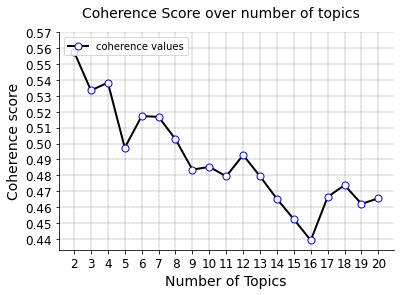

In [26]:
# Show graph over number of topics
limit=total_num_topics; start=2; step=1;
x = range(start, limit+1, step)
y = cvalues

# predefine the graph results 
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [12.00, 6.00]
#plt.rcParams["figure.autolayout"] = True
ticksize = 12
labelsize = 14
markersize = 7
markercolor = 'blue'

#plot the graph
plt.plot(x, y, color='black', linestyle='-', linewidth = 2,
         marker='o', markerfacecolor='white', markeredgecolor=markercolor, markersize=markersize, label ="coherence values")

# define range on axes
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize = ticksize)
plt.yticks(np.arange(round(min(y),2), max(y)+0.02, 0.01), fontsize = ticksize)

# name axes
plt.xlabel("Number of Topics", fontsize = labelsize)
plt.ylabel("Coherence score", fontsize = labelsize)

# title & legend
plt.suptitle("Coherence Score over number of topics", fontsize = 14, y = 0.97)
plt.legend(loc='upper left')

#remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

#grid
plt.grid(color = 'black',which = 'both', linestyle = '--', linewidth = 0.25)

# print plot
plt.show()

In [28]:
def compute_coherence_values_a(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [29]:
grid = {}
grid['Validation_Set'] = {}

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.11))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.11))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=len(alpha)*len(beta))
    
    # iterate through validation corpuses
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = compute_coherence_values_a(corpus=corpus, dictionary=id2word, 
                                          k=7, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(7)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

            pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [57:58<00:00, 31.63s/it]


In [30]:
model_res = pd.DataFrame(model_results)
model_res.sort_values(by = ['Coherence'],ascending = False)

,Topics,Alpha,Beta,Coherence
62,7,0.67,0.23,0.567972
90,7,symmetric,0.01,0.567416
72,7,0.78,0.23,0.566829
63,7,0.67,0.34,0.566488
82,7,0.89,0.23,0.564985
...,...,...,...,...
68,7,0.67,0.89,0.471041
58,7,0.56,0.89,0.469656
78,7,0.78,0.89,0.462177
87,7,0.89,0.78,0.460299


In [31]:
best_alpha = 0.67
best_beta = 0.23
best_num_top = 7

final_LDA_a = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=best_num_top, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=best_alpha,
                                           eta=best_beta)
pprint(final_LDA_a.print_topics())

coherence_LDA_a = compute_coherence_values_a(corpus=corpus, dictionary=id2word, 
                                          k=best_num_top, a=best_alpha, b=best_beta)

[(0,
  '0.035*"information" + 0.024*"use" + 0.023*"datum" + 0.017*"personal" + '
  '0.011*"collect" + 0.009*"include" + 0.009*"right" + 0.009*"email" + '
  '0.008*"provide" + 0.008*"process"'),
 (1,
  '0.014*"collection" + 0.014*"art" + 0.009*"eth" + 0.008*"unique" + '
  '0.008*"project" + 0.008*"artist" + 0.007*"create" + 0.007*"mint" + '
  '0.007*"opensea" + 0.007*"piece"'),
 (2,
  '0.032*"claim" + 0.024*"wallet" + 0.022*"set" + 0.016*"connect" + '
  '0.016*"buy" + 0.012*"product" + 0.011*"order" + 0.010*"opensea" + '
  '0.009*"phase" + 0.009*"blocknumber_number"'),
 (3,
  '0.013*"community" + 0.011*"game" + 0.010*"team" + 0.009*"world" + '
  '0.008*"collection" + 0.007*"metaverse" + 0.007*"create" + 0.007*"token" + '
  '0.006*"join" + 0.006*"project"'),
 (4,
  '0.027*"infinite" + 0.011*"game" + 0.007*"card" + 0.006*"wizard" + '
  '0.005*"farmer" + 0.005*"lore" + 0.005*"voxie" + 0.004*"new" + '
  '0.004*"player" + 0.004*"home"'),
 (5,
  '0.037*"own" + 0.025*"infinite_irl" + 0.010*"pu

In [32]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

topic_data2 = pyLDAvis.gensim_models.prepare(final_LDA_a, corpus, id2word) 
topic_data2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.254544  0.052965       1        1  28.391436
3      0.006255 -0.183974       2        1  25.046007
1      0.031606 -0.174873       3        1  15.711072
0     -0.190554  0.088500       4        1  12.334380
4      0.184341 -0.071080       5        1  10.982036
2      0.030226  0.033558       6        1   5.310721
5      0.192670  0.254904       7        1   2.224347, topic_info=             Term         Freq        Total Category  logprob  loglift
377   information  1756.000000  1756.000000  Default  30.0000  30.0000
94          claim  1364.000000  1364.000000  Default  29.0000  29.0000
1892     infinite  1054.000000  1054.000000  Default  28.0000  28.0000
258         datum  1042.000000  1042.000000  Default  27.0000  27.0000
456           own   607.000000   607.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1656    verwenden    27.807854    34.553948   Topic7  -5.6393   3.5885
4098        drink    25.707277    31.267982   Topic7  -5.7178   3.6099
567        server    41.589255   257.930060   Topic7  -5.2367   1.9809
1356         tool    26.923560   281.876832   Topic7  -5.6716   1.4572
1904   tournament    23.723437    89.028269   Topic7  -5.7981   2.4832

[460 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
88        1  0.424039  access
88        2  0.289063  access
88        3  0.102725  access
88        4  0.163643  access
88        6  0.019709  access
...     ...       ...     ...
82        6  0.025030    work
83        2  0.795267   world
83        3  0.087776   world
83        5  0.111041   world
83        6  0.005288   world

[843 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 2, 1, 5, 3, 6])

In [33]:
#save inter topic distance map
pyLDAvis.save_html(topic_data2, '220711_pyLDA_NFT_LDA_a.html')

In [34]:
all_topics = {} # Create empty dictionary
num_terms = 20 # Adjust number of words to represent each topic
lambd = 0.5 # Set the lambda parameter after viewing Intertopic Distance Map
for i in range(1,best_num_top+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data2.topic_info[topic_data2.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [35]:
# show topic dataframe 
topic_words = pd.DataFrame(all_topics).T
topic_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 1,use,right,agree,content,site,license,agreement,include,purchase,rtfkt,party,relate,arbitration,service,provide,transaction,otherwise,provision,applicable,display
Topic 2,community,team,game,world,build,metaverse,member,join,veefriend,token,utility,experience,stake,create,collection,people,project,learn,cat,fren
Topic 3,eth,art,collection,mint,piece,dgenesis,artist,unique,generative,print,trait,drop,original,project,punk,eulerbeat,genart,shape,bridge,opensea
Topic 4,information,datum,personal,collect,email,request,process,somnium_space,use,privacy_policy,contact,browser,somnium,privacy,cool_cat,protect,opt,address,visit,guardian
Topic 5,infinite,card,wizard,farmer,voxie,farm,battle,lore,game,wax,carrot,pack,fox,creature,weapon,season,warrior,player,black,land
Topic 6,claim,set,blocknumber_number,revv,gmoney,wallet,phase,connect,buy,order,hoot,bored_ape,product,expand_more,chibi,chibi_lab,admit_one,wns_early,twig,physical
Topic 7,infinite_irl,own,punk_valued,car,driver,metasaur,robopet,artvatar,superlativess_superlativess,shame,hashmask,punk_value,race,roboto,riot_racer,desperate_apewive,nct,moonbird,lazy,dmt


In [37]:
# tabelize data to display in thesis
table_data = {
    "Model":["LDA_a"],
    "Words initial":[num_words],
    "Words after preprocess":[words_total],
    "Number of Topics":[best_num_top],
    "LDA Alpha":[best_alpha],
    "LDA Beta":[best_beta],
    "LDA coherrence":[coherence_LDA_a],
    "LDA Lambda":[lambd]
    }

table_inf = pd.DataFrame(table_data)

In [38]:
# display info table
table_inf

,Model,Words initial,Words after preprocess,Number of Topics,LDA Alpha,LDA Beta,LDA coherrence,LDA Lambda
0,LDA_a,698042,351614,7,0.67,0.23,0.567972,0.5
